# Import Libraries

In [95]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, f1_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import make_pipeline

In [99]:
comb = pd.read_csv("../datasets/NH3-UK/nh3_combined.csv")

# Combine the dataframs using merge function
comb['time'] = pd.to_datetime(comb['time'])

# Smoothen the data
comb = comb.drop(comb[comb['NH4_N_MGL'] > 3].index)
comb = comb.drop(comb[comb['NH4_N_MGL'] < 0].index)

89628


# Preprocessing

79850
10150


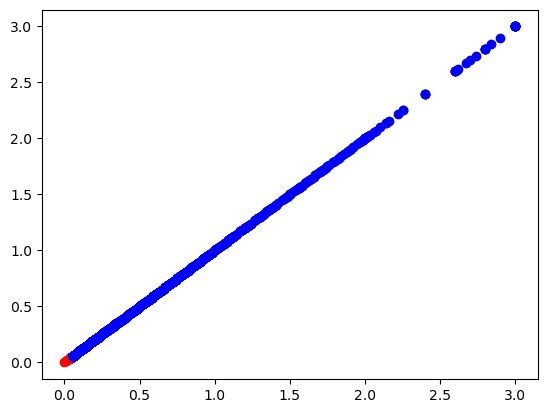

In [9]:
x = comb.sample(9000)
dec = x[x['decreaseFeed'] == 1]
print(len(dec) * 10)
man = x[x['decreaseFeed'] == 0]
print(len(man) * 10)
plt.plot(man['NH4_N_MGL'], man['NH4_N_MGL'], 'ro')
plt.plot(dec['NH4_N_MGL'], dec['NH4_N_MGL'], 'bo')
plt.show()


# Feature Selection

In [30]:
samp = comb.sample(10000)
# get hour and prevamm
samp['hour'] = samp['time'].dt.hour
samp['prev_amm'] = samp['NH4_N_MGL'].shift(1)

# drop na
samp = samp.dropna(subset=['NH4_N_MGL', 'PH', 'DO_MGL', 'hour', 'prev_amm'])

X = samp[['PH', 'pressure_msl (hPa)', 'DO_MGL', 'diffuse_radiation (W/m²)', 'temperature_2m (°C)']].values
y = samp['NH4_N_MGL'].values
regressor = RandomForestRegressor(n_estimators=50)
regressor.fit(X, y)

print(regressor.feature_importances_)

[0.12887404 0.39954869 0.2220481  0.12582496 0.12370421]


# Classification Methods

In [6]:
# split testset into training and tetsing
test = cis.copy(True)
X_train,X_test,y_train,y_test = train_test_split(test[['DO_MGL','PH','precipitation (mm)','pressure_msl (hPa)', 'direct_radiation (W/m²)']], 
        test['decreaseFeed'], test_size=0.2)

In [14]:
def stats(y_pred, y_test):
    # add F1 score, ROC AUC
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tp = cm.data[0, 0]
    tn = cm.data[0, 1]
    fp = cm.data[1, 0]
    fn = cm.data[1, 1]

    print("Precision : ", tp/(tp + tn))
    print("Recall: ", tp/(tp + fp))
    print("Accuracy: ", (tp + fn)/(tp + tn + fp + fn))

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [13]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

F1 Score:  0.5734518844913054
ROC AUC Score:  0.5707071421576654
[[3563 2741]
 [2680 3644]]
Precision :  0.5651967005076142
Recall:  0.5707192055101714
Accuracy:  0.5707158694963573
Mean Absolute Error (MAE): 0.4292841305036427
Root Mean Squared Error (RMSE): 0.8094428822867059


In [14]:
print("------ Polynomial SVC Results ------")
clf = make_pipeline(preprocessing.RobustScaler(), NuSVC(kernel='rbf', gamma='auto', degree=3, nu=0.5))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

print("------ Exponential SVC Results ------")
clf = make_pipeline(preprocessing.QuantileTransformer(), SVC(kernel='poly', gamma='auto', degree=9))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Polynomial SVC Results ------
F1 Score:  0.5700138352872642
ROC AUC Score:  0.5322510912421297
[[2809 3495]
 [2410 3914]]
Precision :  0.4455901015228426
Recall:  0.538225713738264
Accuracy:  0.5323883433639531
Mean Absolute Error (MAE): 0.46761165663604687
Root Mean Squared Error (RMSE): 0.8269349207180704
------ Exponential SVC Results ------
F1 Score:  0.6693760984182776
ROC AUC Score:  0.5225830732653304
[[ 514 5790]
 [ 230 6094]]
Precision :  0.08153553299492386
Recall:  0.6908602150537635
Accuracy:  0.5232815964523282
Mean Absolute Error (MAE): 0.47671840354767187
Root Mean Squared Error (RMSE): 0.8309319906542257


In [17]:
print("------ Boosting Results ------")
model = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingClassifier(learning_rate=0.01, max_depth=3, criterion='squared_error'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Bagging Results ------")
# import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
clf = make_pipeline(preprocessing.QuantileTransformer(), BaggingClassifier(n_jobs=5, base_estimator=DecisionTreeClassifier(), n_estimators=100))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)


print("------ Stacking Results ------")
neural = ('nn', make_pipeline(preprocessing.SplineTransformer(), MLPClassifier(hidden_layer_sizes=(16, 32), activation='relu', max_iter=200000)))
clf = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=24, criterion='entropy', max_features='sqrt')), 
    ('svm', SVC(kernel='rbf')),
    ('gb', GradientBoostingClassifier(max_depth=2))
    ])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Boosting Results ------
F1 Score:  0.6149165236386331
ROC AUC Score:  0.6091002831048908
[[3751 2553]
 [2383 3941]]
Precision :  0.595019035532995
Recall:  0.6115096185197261
Accuracy:  0.6091225847323408
Mean Absolute Error (MAE): 0.3908774152676592
Root Mean Squared Error (RMSE): 0.7906970972523976
------ Bagging Results ------
F1 Score:  0.7867986798679868
ROC AUC Score:  0.7954410640955252
[[5276 1028]
 [1556 4768]]
Precision :  0.8369289340101523
Recall:  0.772248243559719
Accuracy:  0.7953753563509661
Mean Absolute Error (MAE): 0.2046246436490339
Root Mean Squared Error (RMSE): 0.6725730854285915
------ Stacking Results ------
F1 Score:  0.8112538419103159
ROC AUC Score:  0.8103364790324186
[[5086 1218]
 [1177 5147]]
Precision :  0.8067893401015228
Recall:  0.8120708925435095
Accuracy:  0.8103420969274627
Mean Absolute Error (MAE): 0.18965790307253722
Root Mean Squared Error (RMSE): 0.659922196528531


In [16]:
print("------ KNN Results ------")
from sklearn.neighbors import KNeighborsClassifier
k = 2 
knn = KNeighborsClassifier(n_neighbors=k)
# Train the kNN classifier
knn.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test)
stats(y_pred, y_test)

print("------ Decision Tree Results ------")
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Random Forest Results ------")
clf = RandomForestClassifier(max_depth=40, criterion='gini', max_features='log2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ KNN Results ------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 Score:  0.5824532900081235
ROC AUC Score:  0.6747247613635269
[[5648  656]
 [3456 2868]]
Precision :  0.8959390862944162
Recall:  0.6203866432337434
Accuracy:  0.6743744060817232
Mean Absolute Error (MAE): 0.32562559391827683
Root Mean Squared Error (RMSE): 0.7554046140487042
------ Decision Tree Results ------
F1 Score:  0.6988279259385086
ROC AUC Score:  0.7193043501992249
[[4968 1336]
 [2210 4114]]
Precision :  0.7880710659898477
Recall:  0.6921147952075787
Accuracy:  0.7191954387076338
Mean Absolute Error (MAE): 0.2808045612923662
Root Mean Squared Error (RMSE): 0.7279491437142798
------ Random Forest Results ------
F1 Score:  0.796165820088481
ROC AUC Score:  0.8030324511088207
[[5281 1023]
 [1465 4859]]
Precision :  0.8377220812182741
Recall:  0.7828342721612808
Accuracy:  0.8029775102945834
Mean Absolute Error (MAE): 0.19702248970541653
Root Mean Squared Error (RMSE): 0.6662373110880252


# Deep Learning

In [102]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        #'PH_DO', 'Pressure_DO', 'RH_DO', 'CloudCover_DO', 'Temp_DO','DiffuseRad_DO', 'Precip_DO', 'RH_PH', 'RH_Pressure'
        dataframe.rename(columns={'PH': 'ph', 'pressure_msl (hPa)': 'pressure', 'relative_humidity_2m (%)': 'humid', 'diffuse_radiation (W/m²)': 'light', 'temperature_2m (°C)': 'temperature', 'DO_MGL': 'do'}, inplace=True)
        self.numeric_columns = ['ph','do', 'temperature', 'hour', 'previous_ammonia']
        self.transformer = preprocessing.RobustScaler()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns])
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['NH3_MGL']).reset_index(drop=True)
        

    def __len__(self):
        return len(self.data)
    
    def getInverseTransform(self, inputs):
        return self.quantile_transformer.inverse_transform(inputs)

    def __getitem__(self, idx):
        inputs = self.data[self.numeric_columns].iloc[idx].values.astype(np.float32)
        label = self.data['NH4_N_MGL'].iloc[idx].astype(np.float32)
        inputs = torch.tensor(inputs)
        label = torch.tensor(label)
        return inputs, label

In [103]:
class Prev_NH4_Dataset(MyDataset):
    def __init__(self, dataframe, previous_ammonia_list=None):
        self.data = dataframe
        self.numeric_columns = ['ph', 'do', 'temperature', 'hour']
        self.transformer = preprocessing.RobustScaler()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns])
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['previous_ammonia']).reset_index(drop=True)
        
        if previous_ammonia_list is not None:
            self.previous_ammonia = previous_ammonia_list
        else:
            self.previous_ammonia = self.data['previous_ammonia'].tolist()

    def __getitem__(self, idx):
        label = self.data['previous_ammonia'].iloc[idx].astype(np.float32)
        label = torch.tensor(label)

        # Add the previous_ammonia value from the list
        numeric_data = [self.data[col].iloc[idx] for col in self.numeric_columns]
        numeric_data.append(self.previous_ammonia[idx])
        numeric_data = torch.tensor(numeric_data)

        return numeric_data, label


Artifical Neural Network

In [104]:
input_size = 5

# Simple ANN
class CustomANN(nn.Module):
    def __init__(self):
        super(CustomANN, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.CELU(),
            nn.Linear(16, 32),
            nn.CELU(),
            nn.Linear(32, 8),
            nn.CELU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x.float())
        return x * 5  # Scaling the Sigmoid output to range from 0 to 5
ann = CustomANN()

class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[-1, :]

# Simple GRU
gru = nn.Sequential(
    nn.GRU(input_size=input_size, hidden_size=12, num_layers=5, batch_first=True),
    extract_tensor(),
    nn.CELU(),
    nn.Linear(12, 1),
)

# Simple RNN
rnn = nn.Sequential(
    nn.RNN(input_size=input_size, hidden_size=12, num_layers=5, batch_first=True, nonlinearity="relu"),
    extract_tensor(),
    nn.CELU(),
    nn.Linear(12, 1),
)

# Simple LSTM
lstm = nn.Sequential(
    nn.LSTM(input_size=input_size, hidden_size=16, num_layers=7 ,dropout=0.15),
    extract_tensor(),
    nn.Linear(16, 1)
)

# Simple 1D ConvNet
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=2),
            nn.MaxPool1d(kernel_size=2),
            nn.CELU(),
            nn.Conv1d(4, 2, kernel_size=1),
            nn.MaxPool1d(kernel_size=1),
            nn.CELU(),
            nn.Flatten(),
            nn.Linear(2, 32),
            nn.CELU(),
            nn.Linear(32, 32),
            nn.CELU(),
            nn.Linear(32, 8),
            nn.CELU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        return self.main(x)

# Advanced 1D ConvNet
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3),
            nn.CELU(),
            nn.Conv1d(16, 16, kernel_size=2),
            nn.CELU(),
            nn.Conv1d(16, 32, kernel_size=2),
            nn.CELU(),
            nn.Flatten(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.main(x)

# Multihead Attention Network
class AttentionNet1(nn.Module):
    def __init__(self):
        super(AttentionNet1, self).__init__()
        self.attention = nn.MultiheadAttention(input_size, num_heads=5)
        self.final = CustomANN()
        
    def forward(self, x):
        out, _ = self.attention(x, x, x)
        return self.final(out)

# Advanced Multihead Attention Network
class AttentionNet2(nn.Module):
    def __init__(self):
        super(AttentionNet2, self).__init__()
        self.attention1 = nn.MultiheadAttention(input_size, num_heads=5)
        self.attention2 = nn.MultiheadAttention(input_size, num_heads=5)
        self.final = nn.Linear(input_size, 1)
        
    def forward(self, x):
        out, _ = self.attention1(x, x, x)
        out, _ = self.attention2(out, out, out)
        return self.final(out)

# Combination of Conv and Attention
class ComboNet1(nn.Module):
    def __init__(self):
        super(ComboNet1, self).__init__()
        self.conv = nn.Conv1d(input_size, 16, kernel_size=2)
        self.attention = nn.MultiheadAttention(16, num_heads=2)
        self.final = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.conv(x)
        out, _ = self.attention(x, x, x)
        return self.final(out)

# Advanced Combination of Conv and Attention
class ComboNet2(nn.Module):
    def __init__(self):
        super(ComboNet2, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 16, kernel_size=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=2)
        self.attention = nn.MultiheadAttention(32, num_heads=5)
        self.final = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        out, _ = self.attention(x, x, x)
        return self.final(out)

class StackingPy(nn.Module):
    def __init__(self, models, meta_model):
        super(StackingPy, self).__init__()
        self.models = nn.ModuleList(models)
        self.meta_model = meta_model

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        outputs = torch.stack(outputs, dim=-1)
        return self.meta_model(outputs)

meta_model = nn.Sequential(
    nn.Linear(6, 4),  # 6 models stacked
    nn.CELU(),
    nn.Linear(4, 1)
)

# stacked_model = StackingPy(
#     models=[ann, rnn, lstm, ConvNet1(), ConvNet2(), AttentionNet1(), AttentionNet2(), ComboNet1(), ComboNet2()],
#     meta_model=meta_model
# )

class TransformerNet1():
    def __init__(self):
        super(TransformerNet1, self).__init__()
        self.transformer = nn.Sequential(
            nn.Transformer(d_model=4, nhead=2, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=32, dropout=0.2),
            nn.CELU(),
            nn.Linear(4, 1)
        ) 
        
    def forward(self, x):
        out = self.transformer(x)
        return out

In [105]:
model = ann

loss_fn = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
num_epochs = 1

test = comb.copy(True)

# split testset into training and tetsing
trainset, testset = train_test_split(test, test_size=0.02)

dataset = MyDataset(trainset)
data_loader = DataLoader(dataset, drop_last=True, batch_size=10, shuffle=True)


print(model)
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()

    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = ann(inputs)
        
        labels = labels.view(outputs.shape)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += abs(loss.item())

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

CustomANN(
  (main): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): CELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): CELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): CELU(alpha=1.0)
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Epoch 1, Training Loss: 0.0185


In [106]:
y_test_all = []
y_pred_all = []

dataset = MyDataset(testset)
data_loader = DataLoader(dataset, drop_last=True, batch_size=1, shuffle=True)


# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in data_loader:
        
        # Forward pass to get predictions
        y_pred = model(inputs)
        
        # Ensure labels and predictions are of the same shape
        labels = labels.view(y_pred.shape)
        
        # Convert tensors to numpy arrays and flatten them
        y_pred_flat = y_pred.cpu().numpy().flatten()
        y_test_flat = labels.cpu().numpy().flatten()
        
        # Append to the lists
        y_pred_all.extend(y_pred_flat)
        y_test_all.extend(y_test_flat)

# Convert lists to numpy arrays
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)

# Assuming the stats function calculates metrics for regression and accepts predicted and actual values
stats(y_pred_all, y_test_all)

R2 Score: 0.1668
Mean Absolute Error (MAE): 0.061736703
Root Mean Squared Error (RMSE): 0.37921299267120806


## Neural Network Vis

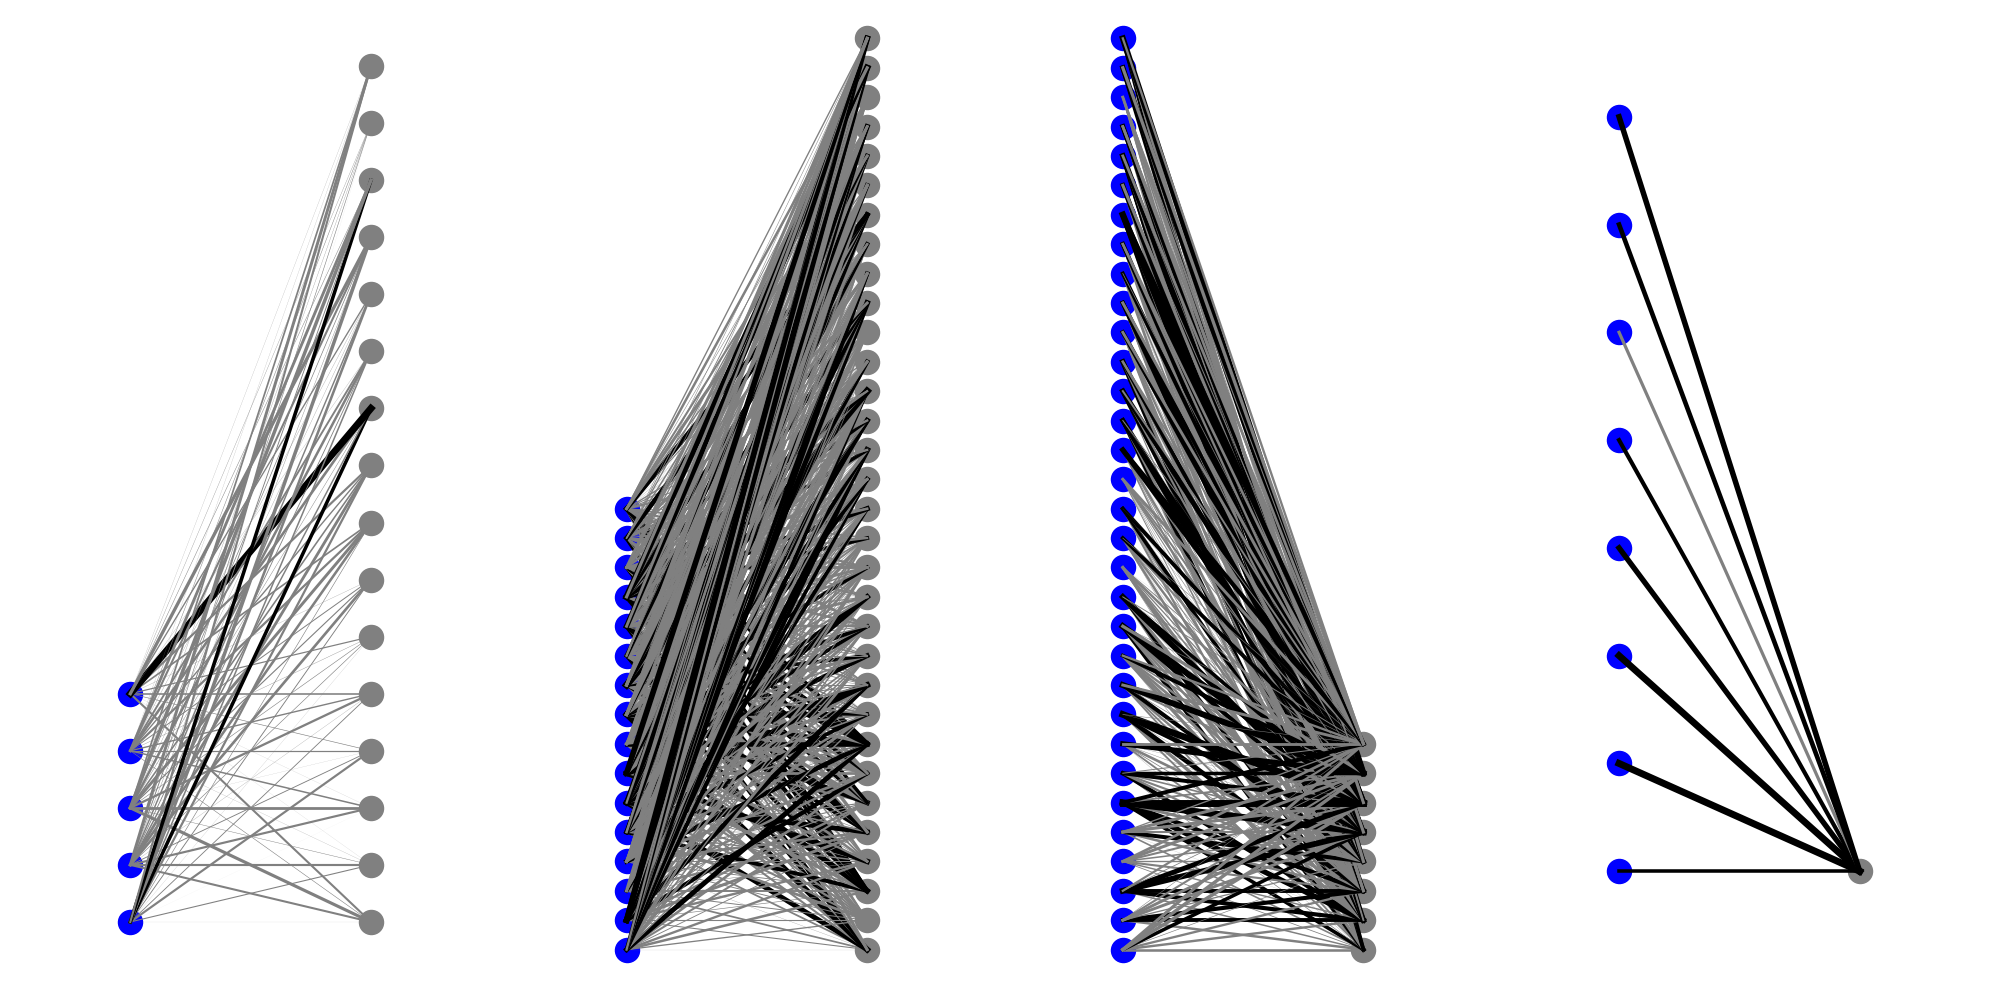

In [107]:
def plot_ann(model):
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    fig, axs = plt.subplots(1, len(layers), figsize=(20, 10))

    for i, layer in enumerate(layers):
        weights = layer.weight.data.abs().numpy()
        max_weight = weights.max()

        # Extracting number of neurons in the current and next layer
        n_neurons_in = weights.shape[1]
        n_neurons_out = weights.shape[0]

        # Plotting neurons of the current layer
        axs[i].scatter([i] * n_neurons_in, range(n_neurons_in), s=300, c='blue')

        # Plotting neurons of the next layer
        axs[i].scatter([i + 1] * n_neurons_out, range(n_neurons_out), c='gray', s=300)

        # Connecting lines (weights) between neurons of the current and next layer
        for j, neuron_out in enumerate(weights):
            for k, neuron_in in enumerate(neuron_out):
                color = 'black' if neuron_in >= 0.5 * max_weight else 'gray'
                axs[i].plot([i, i + 1], [k, j], c=color, lw=neuron_in * 5 / max_weight)

        axs[i].set_xlim(i - 0.5, i + 1.5)
        axs[i].set_ylim(-1, max(n_neurons_in, n_neurons_out))
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
plot_ann(model.main)

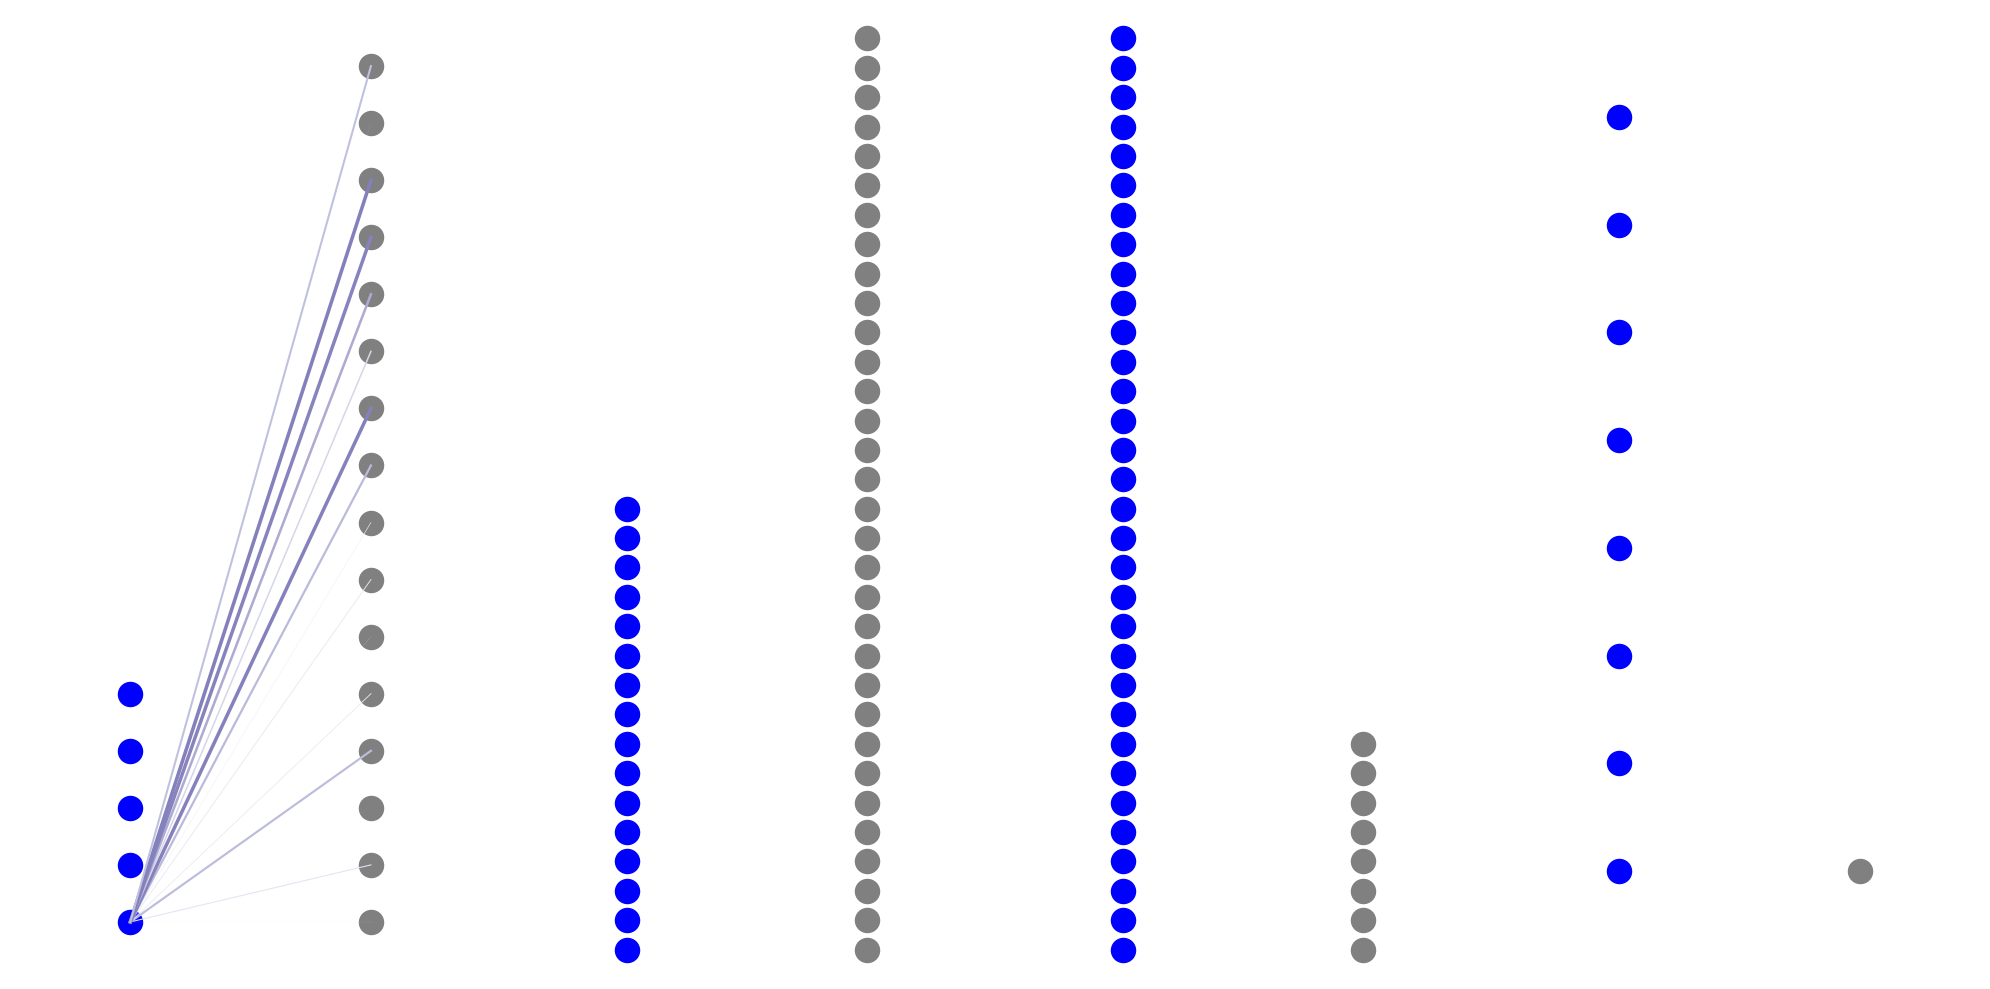

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

def plot_ann(model, node_to_highlight=None):
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    fig, axs = plt.subplots(1, len(layers), figsize=(20, 10))
    
    for i, layer in enumerate(layers):
        weights = layer.weight.data.abs().numpy()
        max_weight = weights.max()

        # Extracting number of neurons in the current and next layer
        n_neurons_in = weights.shape[1]
        n_neurons_out = weights.shape[0]

        # Plotting neurons of the current layer
        axs[i].scatter([i] * n_neurons_in, range(n_neurons_in), s=300, c='blue')

        # Plotting neurons of the next layer
        axs[i].scatter([i + 1] * n_neurons_out, range(n_neurons_out), s=300, c='gray')

        # Connecting lines (weights) between neurons of the current and next layer
        for j, neuron_out in enumerate(weights):
            for k, neuron_in in enumerate(neuron_out):
                if node_to_highlight:
                    layer_idx, neuron_idx = node_to_highlight
                    if (i == layer_idx and k == neuron_idx) or (i + 1 == layer_idx and j == neuron_idx):
                        color_intensity = neuron_in / max_weight
                        color = plt.cm.Purples(np.clip(color_intensity * 1.2, 0, 1))
                        axs[i].plot([i, i + 1], [k, j], c=color, lw=neuron_in * 5 / max_weight)
                else:
                    color_intensity = neuron_in / max_weight
                    color = plt.cm.Purples(color_intensity)
                    
                    axs[i].plot([i, i + 1], [k, j], c=color, lw=neuron_in * 5 / max_weight)

        axs[i].set_xlim(i - 0.5, i + 1.5)
        axs[i].set_ylim(-1, max(n_neurons_in, n_neurons_out))
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_ann(ann.main, node_to_highlight=(0, 0))
# ['ph','do', 'temperature', 'hour', 'previous_ammonia']


## Testing on DB Data

In [117]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

df = pd.read_csv("../datasets/Sensor-predict/spark-july-16.csv")
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
df['datetime'] = pd.to_datetime(df['datetime'])
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/Sensor-predict/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp', 'surface_pressure (hPa)':'pressure'}, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])

# get hour and prevamm
df['hour'] = df['datetime'].dt.hour

x_train = pd.DataFrame()
df['depth'] = 1.2192
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

class WeightedStackingRegressor(StackingRegressor):
    def __init__(self, estimators, final_estimator=RidgeCV(), cv=None, 
                 n_jobs=None, passthrough=False, verbose=0, weights=None):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self.n_jobs = n_jobs
        self.passthrough = passthrough
        self.verbose = verbose
        self.weights = weights or {}
        super().__init__(estimators=estimators, final_estimator=final_estimator, cv=cv, 
                            n_jobs=n_jobs, passthrough=passthrough, verbose=verbose)
        
    def predict(self, X, **predict_params):
        predictions = [
            estimator.predict(X) for estimator in self.estimators_
        ]
        weighted_predictions = sum(
            self.weights.get(name, 1) * prediction for name, prediction in zip(self.named_estimators_.keys(), predictions)
        )
        normalized_predictions = weighted_predictions / sum(self.weights.values())
        
        return normalized_predictions

import pickle
# Load the saved model
with open('./weights/do_svm_weighted.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
df_do = df.rename(columns={'light': 'global_light_energy_w_m2', 'airtemp': 'airtemp_oc', 'humid': 'humid_rh', 'temperature': 'temperature_oc'})
do_pred = loaded_model.predict(df_do[['global_light_energy_w_m2', 'ph', 'temperature_oc', 'humid_rh', 'airtemp_oc','depth', 'hour']])
df['do'] = do_pred

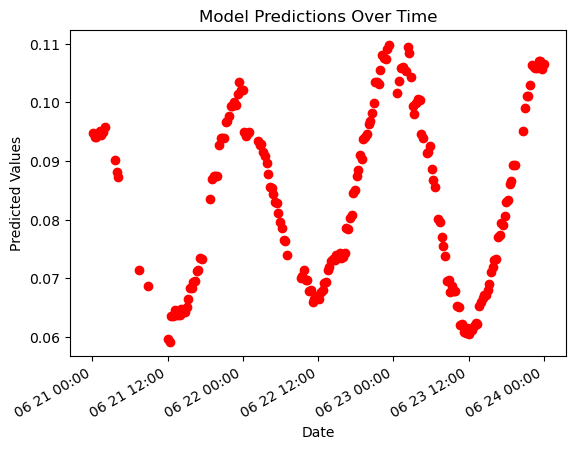

In [118]:
# test the neural net model and store its result in the pandas df
y_test_all = []
y_pred_all = []

# Initialize the previous_ammonia_values list
df['previous_ammonia'] = 0.5
df['NH3_MGL'] = 0.5
previous_ammonia_values = [0.5] * len(df)
dataset = Prev_NH4_Dataset(df, previous_ammonia_values)
data_loader = DataLoader(dataset, shuffle=False, batch_size=1)

y_pred_all = []

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(data_loader):
        # Forward pass to get predictions
        y_pred = model(inputs.float())
        
        # Convert tensors to numpy arrays and flatten them
        y_pred_flat = y_pred.cpu().numpy().flatten()
        
        # Append to the lists
        y_pred_all.extend(y_pred_flat)
        
        # Use the predicted value for the next prediction
        # Update the next instance's previous_ammonia value with the current prediction
        if idx < len(data_loader) - 1:  # Ensure there's a next instance to update
            previous_ammonia_values[idx+1] = y_pred_flat[0]

df['DeepNN'] = y_pred_all


bet = df.loc[df['datetime'].between('2023-06-21', '2023-06-24')]

# Plot the predictions over time
fig, ax = plt.subplots()
ax.plot(bet['datetime'], bet['DeepNN'].astype(float), 'ro')
#ax.plot(bet['datetime'], bet['do'].astype(float), 'bo')

# Format the date labels on the x-axis
myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('Model Predictions Over Time')
plt.show()

# Code Interpreter Supported

In [4]:
cis = pd.read_csv("../datasets/upsampled_data.csv")
cis.columns

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/upsampled_data.csv'

# Regression

In [11]:
from sklearn.metrics import r2_score

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [31]:
comb.to_csv("../datasets/combined.csv", index=False)

In [36]:
# import missing libraries
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

ammData = pd.read_csv("../../../../../../Downloads/final_features_short.csv")

# split train and test
test = comb.copy(True)
test = test.head(600)
# get hour
print(test.columns)
test['time'] = pd.to_datetime(test['time'])
test['hour'] = test['time'].dt.hour
# get previous ammonia as feature
test['prev_amm'] = test['NH4_N_MGL'].shift(1)
test = test.dropna(subset=['prev_amm'])

X_train,X_test,y_train,y_test = train_test_split(test[['PH', 'pressure_msl (hPa)', 'DO_MGL', 'diffuse_radiation (W/m²)', 'cloudcover (%)', 'hour', 'temperature_2m (°C)', 'relativehumidity_2m (%)', 'prev_amm']], test['NH4_N_MGL'], test_size=0.2)

Index(['X', 'Y', 'DO_MGL', 'NO3_N_MGL', 'NO2_N_MGL', 'NH4_N_MGL', 'PH', 'time',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'pressure_msl (hPa)',
       'precipitation (mm)', 'cloudcover (%)', 'direct_radiation (W/m²)',
       'diffuse_radiation (W/m²)'],
      dtype='object')


In [37]:
print("------------ Exponential SVR Results ------------")
svm_spline = make_pipeline(preprocessing.SplineTransformer(), SVR(kernel='rbf', shrinking=True, C=1.5))
svm_spline.fit(X_train, y_train)
y_pred = svm_spline.predict(X_test)
stats(y_pred, y_test)

print("------------ Exponential SVR Results ------------")
svm_minmax = make_pipeline(preprocessing.MinMaxScaler(), SVR(kernel='rbf', shrinking=True, C=1))
svm_minmax.fit(X_train[:len(X_train)//2], y_train[:len(X_train)//2])
svm_minmax.fit(X_train[len(X_train)//2:], y_train[len(X_train)//2:])
y_pred = svm_minmax.predict(X_test)
stats(y_pred, y_test)

------------ Exponential SVR Results ------------
R2 Score: 0.0946
Mean Absolute Error (MAE): 0.9412584743339596
Root Mean Squared Error (RMSE): 1.7957572163185735
------------ Exponential SVR Results ------------
R2 Score: 0.0725
Mean Absolute Error (MAE): 1.0297100577061027
Root Mean Squared Error (RMSE): 1.8066120700130397


In [33]:
print("------------ Random Forest Results ------------")
rf_regressor = make_pipeline(preprocessing.MaxAbsScaler(), RandomForestRegressor(n_estimators=24, max_depth=20))
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
stats(y_pred, y_test)

print("------------ Poly Regression Results ------------")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# Initialize and fit the linear regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
# Predict the target variable for training and test sets
y_pred = poly_reg.predict(X_test_poly)
stats(y_pred, y_test)

print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = make_pipeline(preprocessing.MinMaxScaler(), DecisionTreeRegressor(max_depth=24))
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error'))
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)

------------ Random Forest Results ------------
R2 Score: 0.0983
Mean Absolute Error (MAE): 1.671297087191358
Root Mean Squared Error (RMSE): 2.378085911503622
------------ Poly Regression Results ------------
R2 Score: -31.0892
Mean Absolute Error (MAE): 7.370724666320315
Root Mean Squared Error (RMSE): 5.808273902878282
------------ Decision Tree Results ------------
R2 Score: 0.0991
Mean Absolute Error (MAE): 1.7977499999999997
Root Mean Squared Error (RMSE): 2.3775387659401264
------------ XG Boost Results ------------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (479). n_quantiles is set to n_samples.
  warnings.warn(


R2 Score: 0.1197
Mean Absolute Error (MAE): 1.6560820178665743
Root Mean Squared Error (RMSE): 2.3638271023495894


In [33]:
# Neural Network
print("------ Neural Network Results ------")
from sklearn.neural_network import MLPRegressor
nn = make_pipeline(preprocessing.RobustScaler(), MLPRegressor(hidden_layer_sizes=(7,5), activation='tanh'))
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
stats(y_pred_nn, y_test)

------ Neural Network Results ------
R2 Score: 0.0537
Mean Absolute Error (MAE): 0.08092308225378993
Root Mean Squared Error (RMSE): 0.4280451200110382


In [34]:
# Bagging
print("------ Bagging Results ------")
bagging = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(n_estimators=10))
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)
stats(y_pred_bagging, y_test)

# LinearRegression
print("------ LinearRegression Results ------")
linear_regression = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
linear_regression.fit(X_train, y_train)
y_pred_lr = linear_regression.predict(X_test)
stats(y_pred_lr, y_test)

# Stacking
print("------ Stacking Results ------")
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

model = StackingRegressor(estimators=[
    ('svr', SVR(kernel='rbf', shrinking=False, C=2.5)), 
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),
    ('bag', BaggingRegressor(n_jobs=5)),
    ('bst', GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')),
    ('n1', MLPRegressor(hidden_layer_sizes=(5,7), activation='relu')),
    ('n2', MLPRegressor(hidden_layer_sizes=(5,5), activation='tanh'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

------ Bagging Results ------
R2 Score: -0.0597
Mean Absolute Error (MAE): 0.08819824246696129
Root Mean Squared Error (RMSE): 0.44032280409130914
------ LinearRegression Results ------
R2 Score: 0.0340
Mean Absolute Error (MAE): 0.08381958845469162
Root Mean Squared Error (RMSE): 0.4302558534959071
------ Stacking Results ------
R2 Score: 0.0784
Mean Absolute Error (MAE): 0.0773310459780305
Root Mean Squared Error (RMSE): 0.42522266482169313


In [ ]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Make predictions on the test data
y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.detach().numpy()
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred.reshape(-1, 1)})

In [ ]:
df = pd.read_csv("../datasets/spark-july-16.csv")
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
df['datetime'] = pd.to_datetime(df['datetime'])
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp' }, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])
df.rename(columns={'temperature': 'temperature_2m (°C)', 'light': 'global_light_energy_w_m2', 'humid': 'relativehumidity_2m (%)', 'airtemp': 'airtemp_oc', 'surface_pressure (hPa)': 'pressure_msl (hPa)'}, inplace=True)

x_train = pd.DataFrame()
df['depth'] = 1.2192
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
x_train = df[['ph', 'pressure_msl (hPa)', 'relativehumidity_2m (%)', 'temperature_2m (°C)', 'hour']]
'PH', 'pressure_msl (hPa)', 'DO_MGL', 'diffuse_radiation (W/m²)', 'hour', 'temperature_2m (°C)', 'relativehumidity_2m (%)', 'prev_amm'

# test the neural net model and store its result in the pandas df
'''
y_test_all = []
y_pred_all = []

dataset = MyDataset(x_train)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:

        # Forward pass to get predictions
        y_pred = model(inputs)

        # Convert the predictions and targets to numpy arrays
        y_pred_np = y_pred.numpy()
        y_pred_all.append(y_pred_np)

# Concatenate the lists into a single array
y_pred_all = np.concatenate(y_pred_all)
df['DeepNN'] = y_pred_all
'''


In [26]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

y_pred = svm_spline.predict(x_train)
df['Spline'] = y_pred

fig, ax = plt.subplots()
bet = df.loc[df['datetime'].between('2023-06-23', '2023-06-25')]

ax.plot(bet['datetime'], bet['Spline'].astype(float), 'go')

myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()
plt.show()

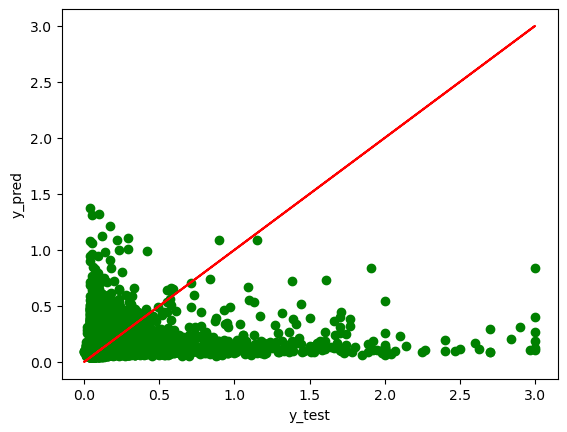

In [27]:
# plot df['y_test'] vs df['y_pred']
plt.plot(df['y_test'], df['y_pred'], 'go')
plt.plot(df['y_test'], df['y_test'], 'r')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()